In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from tqdm import tqdm

In [9]:
df = pd.read_csv("../data/processed/processedData.csv")
X = df.drop("Target", axis=1)
y = df["Target"]

In [10]:
le = LabelEncoder()
yEncoded = le.fit_transform(y)
joblib.dump(le, '../model/labelEncoder.pkl')

smote = SMOTE(random_state=42)
XRes, yRes = smote.fit_resample(X, yEncoded)

scaler = StandardScaler()
scaler.fit(XRes)
joblib.dump(scaler, '../model/scaler.pkl')

X_train, X_test, y_train, y_test = train_test_split(
    XRes, yRes, test_size=0.2, random_state=42
)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3) 
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(64, num_classes)
        self._initializeWeights()
        
    def _initializeWeights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.01)
        x = self.dropout1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.01)
        x = self.dropout2(x)
        x = F.leaky_relu(self.bn3(self.fc3(x)), negative_slope=0.01)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [13]:
n_classes = len(np.unique(yRes))
model = NeuralNetwork(X_train_scaled.shape[1], n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def trainNN(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in tqdm(range(epochs), desc="Training"):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

model = trainNN(model, train_loader, criterion, optimizer, epochs=100)

Training: 100%|██████████| 100/100 [11:34<00:00,  6.95s/it]


In [15]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=5
)
xgb.fit(X_train, y_train)

c:\Users\OSHITH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
def evalModel(model, modelName, is_nn=False):
    if is_nn:
        with torch.no_grad():
            model.eval()
            outputs = model(X_test_tensor)
            y_pred = torch.argmax(outputs, dim=1).numpy()
            y_proba = torch.softmax(outputs, dim=1).numpy()
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
    
    print(f"\n{modelName} Performance:")
    print(classification_report(y_test, y_pred))
    
    if n_classes > 2:  
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else: 
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{modelName} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'../reports/figures/{modelName}_performanceMatrix.png')
    plt.show()
    
    return roc_auc


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      3192
           1       0.95      0.49      0.65      3335
           2       0.81      0.84      0.82      3300
           3       0.83      0.94      0.88      3396
           4       0.82      0.85      0.83      3209

    accuracy                           0.82     16432
   macro avg       0.84      0.82      0.81     16432
weighted avg       0.84      0.82      0.81     16432

ROC-AUC Score: 0.9353


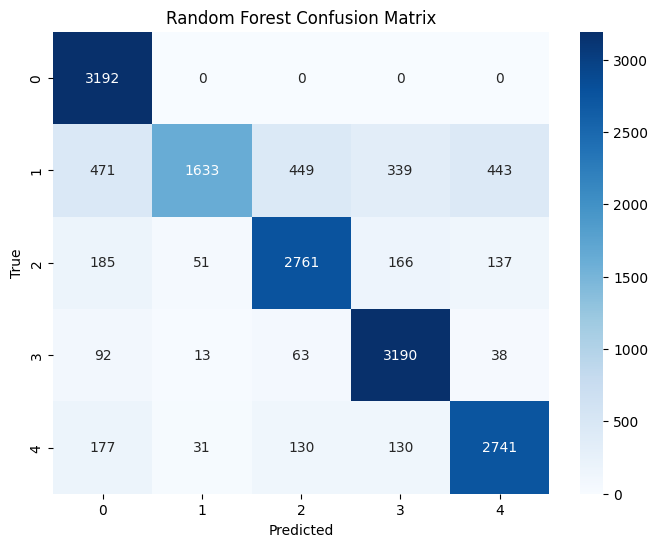


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      3192
           1       0.91      0.68      0.78      3335
           2       0.88      0.85      0.86      3300
           3       0.91      0.94      0.92      3396
           4       0.88      0.88      0.88      3209

    accuracy                           0.87     16432
   macro avg       0.87      0.87      0.87     16432
weighted avg       0.87      0.87      0.87     16432

ROC-AUC Score: 0.9675


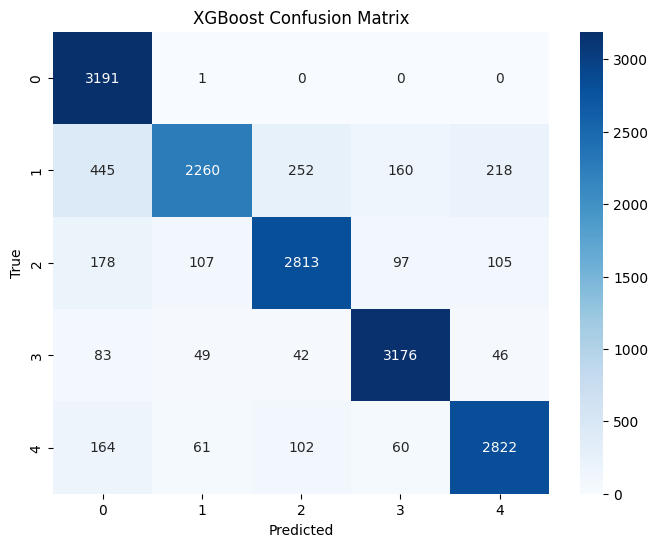


PyTorch Neural Network Performance:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3192
           1       0.83      0.42      0.56      3335
           2       0.86      0.82      0.84      3300
           3       0.93      0.98      0.96      3396
           4       0.73      0.93      0.82      3209

    accuracy                           0.80     16432
   macro avg       0.81      0.80      0.79     16432
weighted avg       0.81      0.80      0.79     16432

ROC-AUC Score: 0.9608


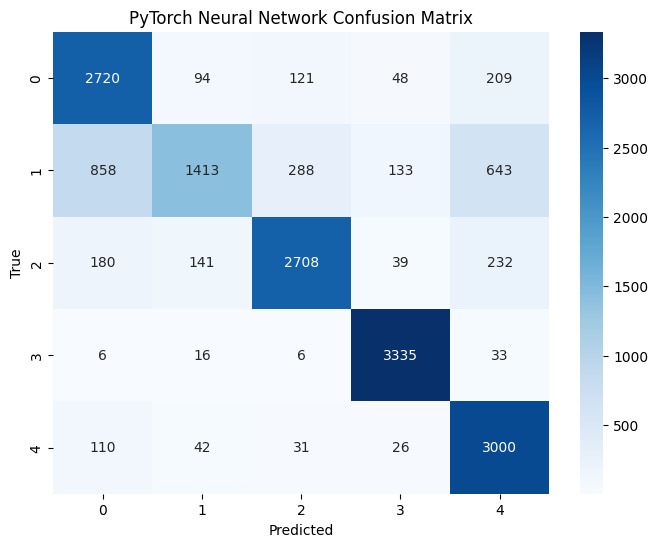


Saving best model: XGBoost with ROC-AUC: 0.9675


In [17]:
models = [
    ('Random Forest', rf, False),
    ('XGBoost', xgb, False),
    ('PyTorch Neural Network', model, True)
]

bestModel = None
bestScore = 0
bestModelName = ""

for name, model, is_nn in models:
    currentScore = evalModel(model, name, is_nn)
    if currentScore > bestScore:
        bestScore = currentScore
        bestModel = model
        bestModelName = name

print(f"\nSaving best model: {bestModelName} with ROC-AUC: {bestScore:.4f}")

if bestModelName == 'PyTorch Neural Network':
    torch.save(model.state_dict(), '../model/bestModel.pth')
else:
    joblib.dump(bestModel, '../model/bestModel.pkl')

In [18]:
metadata = {
    'features': list(X.columns),
    'categorical_features': [
        "Appetite (good/poor)", "Hypertension (yes/no)", "Sugar in urine",
        "Pedal edema (yes/no)", "Albumin in urine", "Pus cells in urine",
        "Bacteria in urine", "Anemia (yes/no)", "Red blood cells in urine",
        "Smoking status", "Diabetes mellitus (yes/no)", 
        "Urinary sediment microscopy results", "Pus cell clumps in urine"
    ],
    'numerical_features': [
        "Serum phosphate level", "Random blood glucose level (mg/dl)",
        "Duration of diabetes mellitus (years)", "C-reactive protein (CRP) level",
        "Blood pressure (mm/Hg)", "Cystatin C level", "Age of the patient",
        "Sodium level (mEq/L)", "Body Mass Index (BMI)", 
        "Red blood cell count (millions/cumm)", "Urine protein-to-creatinine ratio",
        "Cholesterol level", "Urine output (ml/day)"
    ]
}
joblib.dump(metadata, '../model/metadata.pkl')

['../model/metadata.pkl']